In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
from ipywidgets import interact

In [2]:
def gen_list_of_image_names(abs_path, extension):
    list_of_image_names = glob(os.path.join(abs_path, '*'+extension))
    return list_of_image_names

In [3]:
def gen_dateset(list_of_image_names, square=False, newsize=None, color=True):
    dataset = []
    for img_name in list_of_image_names:
        if color:
            img = cv2.imread(img_name,1) #array 720x1280 rgb
        else:
            img = cv2.imread(img_name,0) #array 720x1280 grayscale
        if (img is None):
            print(img_name,'non eksiste')
        else:
            if square:
                img = img[:,280:1000] #subentendendo que a imagem original eh 720x1280
            if newsize:
                img = cv2.resize(img, newsize) 
            dataset.append(img)
    #print(type(img))
#     print(len(dataset))
#     print(type(dataset))
    dataset = np.stack(dataset)
    return dataset

In [4]:
def permutate(ds, labels=None):
    p = np.random.permutation(ds.shape[0])
    ds = ds[p]
    if (labels is not None):
        labels = labels[p]
        return ds, labels
    return ds

In [5]:
path = '/Users/henriquegoncalves/Documents/UFRJ/PF2/Images/imagens_PL0138/'
cl_name = 'anodo'
nc_name = 'duto'

nc = gen_list_of_image_names(os.path.join(path,nc_name),'.jpg')
cl = gen_list_of_image_names(os.path.join(path,cl_name),'.jpg')

print(nc[0])
print(cl[0])

/Users/henriquegoncalves/Documents/UFRJ/PF2/Images/imagens_v1/duto/HD_C_pl0138_VOL055_duto_00-05-22_13.jpg
/Users/henriquegoncalves/Documents/UFRJ/PF2/Images/imagens_v1/peixe/HD_C_pl0138_VOL055_peixe_00-21-17_12.jpg


Separando quais videos são treino, teste e validação

In [6]:
test_video_name = 'HD_C_pl0138_VOL006'
valid_video_name = 'HD_C_pl0138_VOL007'

te_cl_path = [path for path in cl if test_video_name in path]
v_cl_path = [path for path in cl if valid_video_name in path]

tr_cl_path = [path for path in cl if valid_video_name not in path]
tr_cl_path = [path for path in tr_cl_path if test_video_name not in path]


te_ncl_path = [path for path in nc if test_video_name in path]
v_ncl_path = [path for path in nc if valid_video_name in path]

tr_ncl_path = [path for path in nc if valid_video_name not in path]
tr_ncl_path = [path for path in tr_ncl_path if test_video_name not in path]

Gerar os arquivos de dataset e normalizar

In [7]:
%%time
te_cl_data = gen_dateset(te_cl_path,square=True, newsize=(224,224), color=True)
v_cl_data = gen_dateset(v_cl_path,square=True, newsize=(224,224), color=True)
tr_cl_data = gen_dateset(tr_cl_path,square=True, newsize=(224,224), color=True)

te_ncl_data = gen_dateset(te_ncl_path,square=True, newsize=(224,224), color=True)
v_ncl_data = gen_dateset(v_ncl_path,square=True, newsize=(224,224), color=True)
tr_ncl_data = gen_dateset(tr_ncl_path,square=True, newsize=(224,224), color=True)

CPU times: user 6min 42s, sys: 45.3 s, total: 7min 27s
Wall time: 8min 40s


Balancear as classes

In [8]:
assert(len(cl) == (te_cl_data.shape[0]+v_cl_data.shape[0]+tr_cl_data.shape[0]))
assert(len(nc) == (te_ncl_data.shape[0]+v_ncl_data.shape[0]+tr_ncl_data.shape[0]))

tr_m = min(tr_cl_data.shape[0], tr_ncl_data.shape[0])
te_m = min(te_cl_data.shape[0], te_ncl_data.shape[0])
v_m = min(v_cl_data.shape[0], v_ncl_data.shape[0])

tr_cl_data = permutate(tr_cl_data)
te_cl_data = permutate(te_cl_data)
v_cl_data = permutate(v_cl_data)
tr_ncl_data = permutate(tr_ncl_data)
te_ncl_data = permutate(te_ncl_data)
v_ncl_data = permutate(v_ncl_data)

tr_cl_data = tr_cl_data[:tr_m]
te_cl_data = te_cl_data[:te_m]
v_cl_data = v_cl_data[:v_m]
tr_ncl_data = tr_ncl_data[:tr_m]
te_ncl_data = te_ncl_data[:te_m]
v_ncl_data = v_ncl_data[:v_m]

print(tr_cl_data.shape, tr_ncl_data.shape, te_cl_data.shape, te_ncl_data.shape, v_cl_data.shape, v_ncl_data.shape)

(3186, 224, 224, 3) (3186, 224, 224, 3) (51, 224, 224, 3) (51, 224, 224, 3) (174, 224, 224, 3) (174, 224, 224, 3)


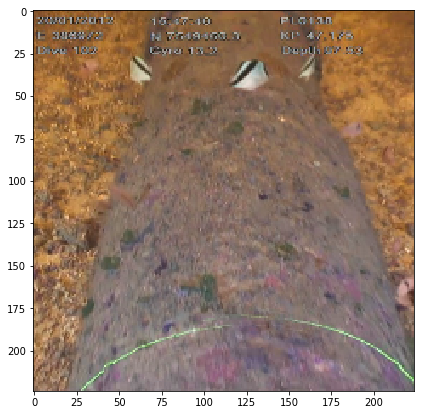

In [9]:
index = 327
plt.figure(figsize=(7,7))
plt.imshow(tr_cl_data[index,:,:,:])

In [10]:
n = 5
dataset = tr_cl_data

def printimg(ds,num_images):
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(ds[i,:].reshape(224,224,3), interpolation='nearest')
        plt.axis('off')

def interprint(x):
    printimg(dataset[x:x+n],n)

interact(interprint, x=(0,len(dataset)//n,n))
print()
# acerto do target de peixe == 73% para as primeiras 100 imagens

interactive(children=(IntSlider(value=315, description='x', max=637, step=5), Output()), _dom_classes=('widget…

In [39]:
X_tr = np.concatenate((tr_cl_data, tr_ncl_data))
Y_tr = np.concatenate((np.ones((tr_m,1)),np.zeros((tr_m,1))))

X_te = np.concatenate((te_cl_data, te_ncl_data))
Y_te = np.concatenate((np.ones((te_m,1)),np.zeros((te_m,1))))

X_v = np.concatenate((v_cl_data, v_ncl_data))
Y_v = np.concatenate((np.ones((v_m,1)),np.zeros((v_m,1))))

X_tr, Y_tr = permutate(X_tr, Y_tr)
X_te, Y_te = permutate(X_te, Y_te)
X_v, Y_v = permutate(X_v, Y_v)

classes = [nc_name.encode(), cl_name.encode()]

This image is of class: peixe
len: 6372


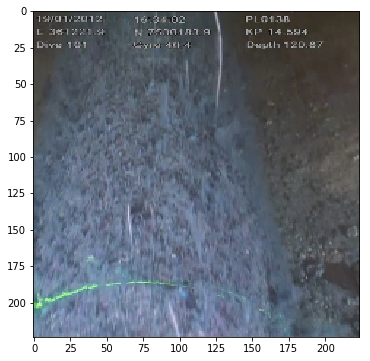

In [40]:
index = 11
plt.figure(figsize=(6,6))
plt.imshow(X_tr[index,:,:,:])
print('This image is of class:',classes[int(Y_tr[index,0])].decode())
print('len:',len(Y_tr))
# fig, axarr = plt.subplots(1,2, figsize=(10,14))
# axarr[0].imshow(X_tr[0,:,:,:])
# axarr[1].imshow(cl_data[0,:,:,:])

In [42]:
path = '../datasets/'
filename = cl_name+'_224x224_color.h5'
f = os.path.join(path, filename)

h5f = h5py.File(f, 'w')
h5f.create_dataset('X_tr', data=X_tr)
h5f.create_dataset('Y_tr', data=Y_tr)
h5f.create_dataset('X_v', data=X_v)
h5f.create_dataset('Y_v', data=Y_v)
h5f.create_dataset('X_te', data=X_te)
h5f.create_dataset('Y_te', data=Y_te)
h5f.create_dataset('classes', data=classes)
h5f.close()

Normalização

In [49]:
import pandas as pd

In [50]:
#names = gen_list_of_image_names('/Users/henriquegoncalves/Documents/UFRJ/PF2/Images/imagens/dano','.jpg')
ds = os.listdir('/Users/henriquegoncalves/Documents/UFRJ/PF2/Images/imagens_v1/peixe/')
df = pd.DataFrame({'classe': ds})
# df = pd.DataFrame({'dano': dano})
df['video'] = df.apply(lambda row: row.classe[:18],axis=1)
print(len(df))
df.groupby(['video'],sort=False).count()

# df['dano']
# video_path = '/Users/henriquegoncalves/Documents/UFRJ/PF2/Videos/'
# videos = [i for i in os.listdir(video_path) if i.endswith(".mp4")]
# for video in videos:
#     video = video.split('.')[0]
# videos = [video.split('.')[0] for video in videos]

# 06 teste, 07 valid

3411


,classe
video,
HD_C_pl0138_VOL055,1224
HD_C_pl0138_VOL017,267
HD_C_pl0138_VOL021,207
HD_C_pl0138_VOL005,177
HD_C_pl0138_VOL018,264
HD_C_pl0138_VOL009,123
HD_C_pl0138_VOL020,153
HD_C_pl0138_VOL007,174
HD_C_pl0138_VOL003,492


In [ ]:
print(len(df)-1411-1317)

In [ ]:
543+537+597+600+648+666+645+585+519+27#+747+609

In [3]:
f = h5py.File('../r50_predictions/dano_resnet50_predicted.h5', 'r')
print(list(f.keys()))


['X_te', 'X_tr', 'X_v', 'classes']
